In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [5]:
import sys
sys.path.append("../")

# Dataframes
command: disjoint speaker split

In [6]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/voxceleb/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Voxc_Dataframe.pkl')

In [7]:
import honk_sv.train as hk
import honk_sv.model as mod
import honk_sv.dataset as dset
import honk_sv.system as svs

### Dataset split

In [15]:
#TODO: correct splits
all_spks = data_df.spk.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[-40:])
si_spks = list(uttrs_counts.index[:-40])

# SI Train

In [26]:
import random 

si_df = data_df[data_df.spk.isin(si_spks)]

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[random] train:120605, val:30151, test:30151


In [19]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_val, 'test':si_random_test}
manifest_dir = "../manifests/voxc/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

TypeError: 'Index' object is not callable

In [9]:
model = "res8-wide"
dataset = "voxc"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=100, batch_size=128,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001,
                     num_workers=32, print_step=100,
                     splice_length = 40
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                dset.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = len(si_spks)
manifest_dir = "manifests/voxc/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))

si_model = si_config['model_class'](si_config)
si_config['output_file'] = "models/voxc/si_voxc_frames_res8w_1.pt"
print(si_model)

SpeechResModel (
  (conv0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): AvgPool2d (size=[4, 3], stride=[4, 3], padding=0, ceil_mode=False, count_include_pad=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn6): Batc

In [58]:
# si_model.load("models/voxc/si_voxc_frames_res8w.pt")
# si_config['n_epochs'] = 0
hk.train(si_config, model=si_model, _collate_fn=hk._random_frames_collate_fn)

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f4b46285898>>
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._shutdown_workers()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 237, in _shutdown_workers
    self.index_queue.put(None)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 354, in put
    self._writer.send_bytes(obj)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocess

train step #99 accuracy: 0.2421875, loss: 4.177387237548828
train step #199 accuracy: 0.2421875, loss: 4.276266574859619
train step #299 accuracy: 0.265625, loss: 3.9817466735839844
train step #399 accuracy: 0.2578125, loss: 3.9527950286865234
train step #499 accuracy: 0.203125, loss: 4.414542198181152
train step #599 accuracy: 0.21875, loss: 4.176668167114258
train step #699 accuracy: 0.2734375, loss: 3.986218214035034
train step #799 accuracy: 0.28125, loss: 3.986651659011841
train step #899 accuracy: 0.25, loss: 4.237125873565674
epoch #0, final dev accuracy: 0.24478019067796608
saving best model...
train step #999 accuracy: 0.265625, loss: 3.9438414573669434
train step #1099 accuracy: 0.265625, loss: 3.9199578762054443
train step #1199 accuracy: 0.2109375, loss: 4.135591983795166
train step #1299 accuracy: 0.25, loss: 3.949500322341919
train step #1399 accuracy: 0.2890625, loss: 3.8404879570007324
train step #1499 accuracy: 0.2578125, loss: 4.059499740600586
train step #1599 accura

train step #12299 accuracy: 0.28125, loss: 4.026044845581055
train step #12399 accuracy: 0.3046875, loss: 3.7904458045959473
train step #12499 accuracy: 0.234375, loss: 3.9121408462524414
train step #12599 accuracy: 0.2734375, loss: 3.941270351409912
train step #12699 accuracy: 0.25, loss: 3.924314260482788
train step #12799 accuracy: 0.296875, loss: 3.902076244354248
train step #12899 accuracy: 0.1875, loss: 4.136517524719238
train step #12999 accuracy: 0.28125, loss: 3.8530654907226562
train step #13099 accuracy: 0.28125, loss: 3.721367597579956
epoch #13, final dev accuracy: 0.2567717161016949
train step #13199 accuracy: 0.265625, loss: 4.134958744049072
train step #13299 accuracy: 0.2890625, loss: 3.741032600402832
train step #13399 accuracy: 0.203125, loss: 4.2119669914245605
train step #13499 accuracy: 0.265625, loss: 3.97184157371521
train step #13599 accuracy: 0.28125, loss: 4.124701976776123
train step #13699 accuracy: 0.265625, loss: 3.7815630435943604
train step #13799 accur

epoch #25, final dev accuracy: 0.2664936440677966
saving best model...
train step #24499 accuracy: 0.328125, loss: 3.752011299133301
train step #24599 accuracy: 0.296875, loss: 3.706578254699707
train step #24699 accuracy: 0.28125, loss: 3.8855602741241455
train step #24799 accuracy: 0.2734375, loss: 4.014851093292236
train step #24899 accuracy: 0.265625, loss: 3.997891426086426
train step #24999 accuracy: 0.265625, loss: 3.851119041442871
train step #25099 accuracy: 0.2265625, loss: 3.879394054412842
train step #25199 accuracy: 0.3515625, loss: 3.7623820304870605
train step #25299 accuracy: 0.2421875, loss: 3.787954807281494
train step #25399 accuracy: 0.234375, loss: 3.9907121658325195
epoch #26, final dev accuracy: 0.26353283898305085
train step #25499 accuracy: 0.28125, loss: 3.8612492084503174
train step #25599 accuracy: 0.203125, loss: 4.114034175872803
train step #25699 accuracy: 0.2890625, loss: 3.8466856479644775
train step #25799 accuracy: 0.2578125, loss: 4.052722930908203
t

train step #36599 accuracy: 0.3046875, loss: 3.7294676303863525
train step #36699 accuracy: 0.2890625, loss: 3.8033111095428467
epoch #38, final dev accuracy: 0.26854608050847456
train step #36799 accuracy: 0.2890625, loss: 3.761760711669922
train step #36899 accuracy: 0.28125, loss: 3.937309980392456
train step #36999 accuracy: 0.328125, loss: 3.5092391967773438
train step #37099 accuracy: 0.28125, loss: 3.8628756999969482
train step #37199 accuracy: 0.2265625, loss: 3.8205888271331787
train step #37299 accuracy: 0.21875, loss: 4.19265079498291
train step #37399 accuracy: 0.2734375, loss: 4.145400524139404
train step #37499 accuracy: 0.2890625, loss: 3.840805768966675
train step #37599 accuracy: 0.265625, loss: 3.975008249282837
epoch #39, final dev accuracy: 0.26949152542372884
train step #37699 accuracy: 0.2734375, loss: 4.018747806549072
train step #37799 accuracy: 0.25, loss: 4.09405517578125
train step #37899 accuracy: 0.28125, loss: 3.718904972076416
train step #37999 accuracy: 

train step #48599 accuracy: 0.3125, loss: 3.6619207859039307
train step #48699 accuracy: 0.28125, loss: 3.7151310443878174
train step #48799 accuracy: 0.2734375, loss: 3.7996740341186523
train step #48899 accuracy: 0.203125, loss: 3.8925294876098633
epoch #51, final dev accuracy: 0.27728548728813557
saving best model...
train step #48999 accuracy: 0.296875, loss: 3.8892128467559814
train step #49099 accuracy: 0.25, loss: 3.8863439559936523
train step #49199 accuracy: 0.328125, loss: 3.5202481746673584
train step #49299 accuracy: 0.2421875, loss: 3.956813097000122
train step #49399 accuracy: 0.296875, loss: 3.813704490661621
train step #49499 accuracy: 0.3046875, loss: 3.7541534900665283
train step #49599 accuracy: 0.25, loss: 3.846198558807373
train step #49699 accuracy: 0.3125, loss: 3.792560577392578
train step #49799 accuracy: 0.25, loss: 3.8326892852783203
train step #49899 accuracy: 0.34375, loss: 3.5940921306610107
epoch #52, final dev accuracy: 0.2783845338983051
saving best mod

train step #60599 accuracy: 0.3515625, loss: 3.482417583465576
train step #60699 accuracy: 0.2578125, loss: 3.9813244342803955
train step #60799 accuracy: 0.3046875, loss: 3.71651554107666
train step #60899 accuracy: 0.2890625, loss: 3.661346435546875
train step #60999 accuracy: 0.3125, loss: 3.6197307109832764
train step #61099 accuracy: 0.2734375, loss: 3.473804235458374
train step #61199 accuracy: 0.3203125, loss: 3.6669673919677734
epoch #64, final dev accuracy: 0.2787076271186441
train step #61299 accuracy: 0.34375, loss: 3.572035789489746
train step #61399 accuracy: 0.265625, loss: 3.719458818435669
train step #61499 accuracy: 0.2734375, loss: 3.800983190536499
train step #61599 accuracy: 0.296875, loss: 3.8815300464630127
train step #61699 accuracy: 0.34375, loss: 3.6210944652557373
train step #61799 accuracy: 0.2421875, loss: 3.9448256492614746
train step #61899 accuracy: 0.3203125, loss: 3.6156692504882812
train step #61999 accuracy: 0.2890625, loss: 3.8714473247528076
train s

train step #72599 accuracy: 0.3203125, loss: 3.6387009620666504
train step #72699 accuracy: 0.3515625, loss: 3.440981864929199
train step #72799 accuracy: 0.3203125, loss: 3.5809199810028076
train step #72899 accuracy: 0.296875, loss: 3.6013741493225098
train step #72999 accuracy: 0.34375, loss: 3.510887861251831
train step #73099 accuracy: 0.234375, loss: 4.025882720947266
train step #73199 accuracy: 0.234375, loss: 3.837940216064453
train step #73299 accuracy: 0.375, loss: 3.5096237659454346
train step #73399 accuracy: 0.2265625, loss: 3.817394495010376
epoch #77, final dev accuracy: 0.2819782838983051
train step #73499 accuracy: 0.3359375, loss: 3.5605082511901855
train step #73599 accuracy: 0.296875, loss: 3.651632308959961
train step #73699 accuracy: 0.3359375, loss: 3.7000045776367188
train step #73799 accuracy: 0.3203125, loss: 3.484530448913574
train step #73899 accuracy: 0.34375, loss: 3.641610622406006
train step #73999 accuracy: 0.265625, loss: 3.9335546493530273
train step 

epoch #89, final dev accuracy: 0.2913771186440678
saving best model...
train step #84799 accuracy: 0.3203125, loss: 3.676720142364502
train step #84899 accuracy: 0.390625, loss: 3.5005083084106445
train step #84999 accuracy: 0.25, loss: 3.7066571712493896
train step #85099 accuracy: 0.25, loss: 3.7964060306549072
train step #85199 accuracy: 0.2890625, loss: 3.5945591926574707
train step #85299 accuracy: 0.28125, loss: 3.5681796073913574
train step #85399 accuracy: 0.265625, loss: 3.8676888942718506
train step #85499 accuracy: 0.2578125, loss: 3.772907018661499
train step #85599 accuracy: 0.328125, loss: 3.433354616165161
train step #85699 accuracy: 0.296875, loss: 3.737520694732666
epoch #90, final dev accuracy: 0.28979872881355934
train step #85799 accuracy: 0.296875, loss: 3.69010329246521
train step #85899 accuracy: 0.265625, loss: 3.7847838401794434
train step #85999 accuracy: 0.3359375, loss: 3.7734272480010986
train step #86099 accuracy: 0.3203125, loss: 3.6585819721221924
train 

# SV Enrollment & Test

In [11]:
import random
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [12]:
enroll_spks

['Olivia_Munn', 'Sam_Palladio', 'Ellen_Wong', 'Karl_Malden', 'Nina_Arianda']

In [13]:
test_spks

['Violante_Placido',
 'Michael_Weatherly',
 'Thomas_Jane',
 'Damon_Wayans',
 'Shemar_Moore',
 'Beth_Grant',
 'Shiri_Appleby',
 'Claudia_Lee',
 'Steven_Soderbergh',
 'Marisa_Miller',
 'Blake_Michael',
 'Jacqueline_MacInnes_Wood',
 'Joan_Cusack',
 'Walter_Matthau',
 'Alex_Pettyfer',
 'Julianne_Nicholson',
 'Donal_Logue',
 'Steve_Harvey',
 'Raoul_Bova',
 'Audrina_Patridge',
 'Ellen_Burstyn',
 'Jason_Dohring',
 'Max_Thieriot',
 'Chris_Lowell',
 'Leslie_Bibb',
 'Fanny_Ardant',
 'Gary_Busey',
 'Kim_Zolciak-Biermann',
 'Katie_Stevens',
 'Dane_Cook',
 'Will_Mellor',
 'Shannen_Doherty',
 'Iain_Glen',
 'Jennifer_Coolidge',
 'Steve_Burton']

In [14]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df[data_df.spk.isin(sv_spks)]
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(frac=enroll_pts)
    devs = spk_df.drop(index=enls.index)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=2*len(dev_uttrs))

In [28]:
# dev_uttrs.to_pickle("./dev_uttrs.pkl")
# test_uttrs.to_pickle("./test_uttrs.pkl")
enroll_uttrs = pd.read_pickle("./enroll_uttrs.pkl")
dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
test_uttrs = pd.read_pickle("./test_uttrs.pkl")
enroll_spks = list(dev_uttrs.spk.unique()[::-1])

In [24]:
import csv
import random

manifest_dir = "./manifests/voxc/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/voxc/enroll/enroll_voxc_Julianne_Nicholson_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Alex_Pettyfer_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Thomas_Jane_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Chris_Lowell_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Shiri_Appleby_manifest.csv was written


In [29]:
si_model = si_config['model_class'](si_config)
si_model.load("models/voxc/si_voxc_frames_res8w_1.pt")

In [43]:
# enrolling speakers
# generating speaker models
si_config['batch_size'] = 1
si_config['input_length'] = int(16000*4)
manifest_dir = "./manifests/voxc/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_frame(si_config, model=si_model)

In [44]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

Nina_Arianda, Jason_Dohring: -0.47
Nina_Arianda, Joan_Cusack: 0.39
Nina_Arianda, Walter_Matthau: -0.33
Nina_Arianda, Max_Thieriot: -0.21
Jason_Dohring, Joan_Cusack: -0.54
Jason_Dohring, Walter_Matthau: 0.32
Jason_Dohring, Max_Thieriot: 0.57
Joan_Cusack, Walter_Matthau: -0.56
Joan_Cusack, Max_Thieriot: -0.39
Walter_Matthau, Max_Thieriot: 0.09


In [45]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [46]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

In [47]:
for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

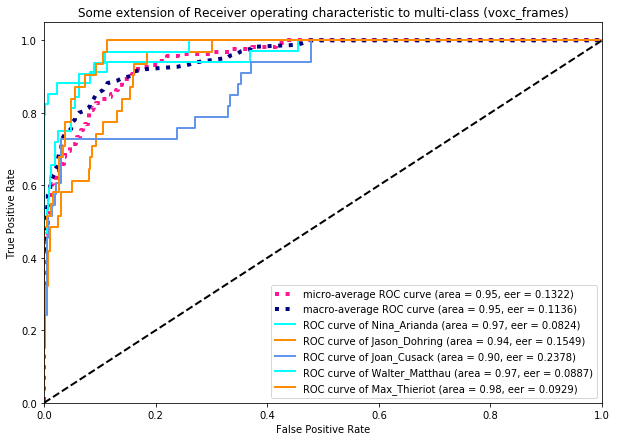

In [48]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class (voxc_frames)')
plt.legend(loc="lower right")
plt.show()